### Train/Val/Test Split

Run counts:
  Train runs: 600
  Val runs:   200
  Test runs:  200


c:\Users\custu\.conda\envs\tefault\lib\site-packages\xgboost\training.py:199: UserWarning: [15:11:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model expects n_features = 156

Validation Accuracy: 0.9272
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.88     49800
           1       0.99      0.98      0.98     12000
           2       0.99      0.93      0.96     12000
           4       0.98      0.99      0.98     12000
           5       0.99      0.99      0.99     12000
           6       1.00      0.99      1.00     12000
           7       1.00      0.99      1.00     12000
           8       0.99      0.83      0.90     12000
          10       0.98      0.69      0.81     12000
          11       0.99      0.90      0.94     12000
          12       0.99      0.91      0.95     12000
          13       0.98      0.67      0.80     12000
          14       1.00      0.99      0.99     12000

    accuracy                           0.93    193800
   macro avg       0.97      0.91      0.94    193800
weighted avg       0.94      0.93      0

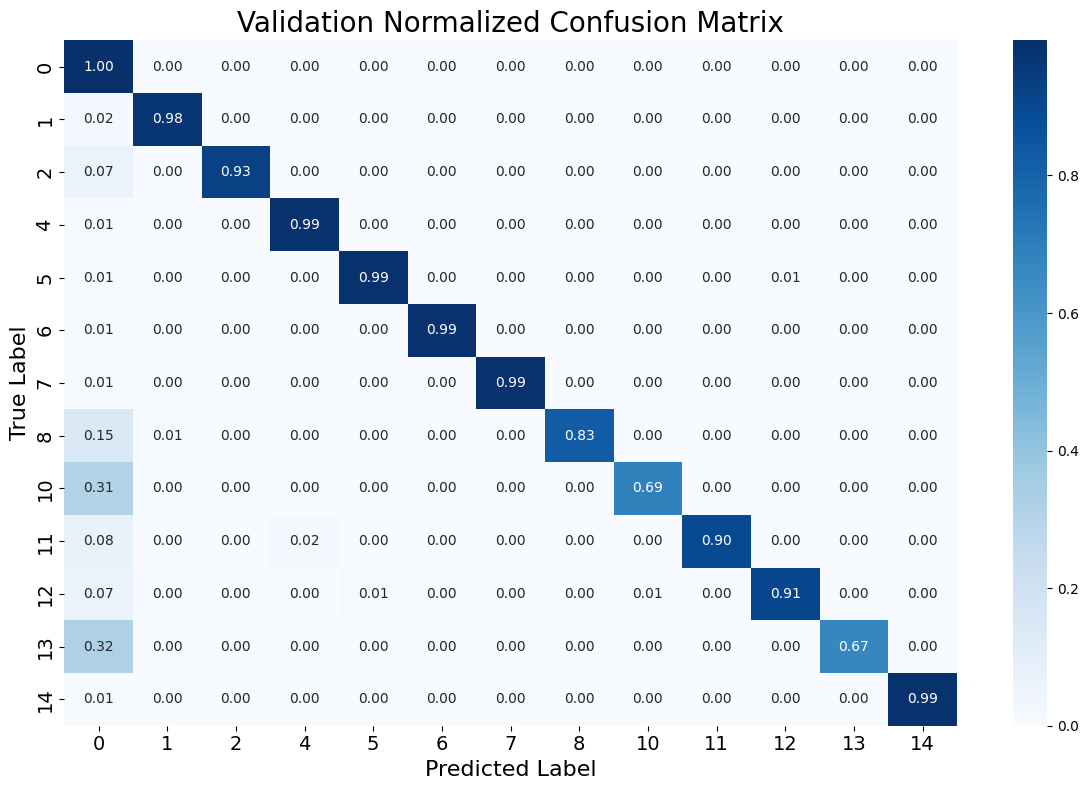


Test Accuracy: 0.9228
Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     49800
           1       0.98      0.98      0.98     12000
           2       0.99      0.93      0.96     12000
           4       0.98      0.99      0.98     12000
           5       0.98      0.99      0.98     12000
           6       1.00      0.99      1.00     12000
           7       1.00      0.99      1.00     12000
           8       0.99      0.82      0.90     12000
          10       0.97      0.67      0.79     12000
          11       0.99      0.89      0.94     12000
          12       0.98      0.90      0.94     12000
          13       0.99      0.64      0.78     12000
          14       1.00      0.99      0.99     12000

    accuracy                           0.92    193800
   macro avg       0.97      0.91      0.93    193800
weighted avg       0.94      0.92      0.92    193800



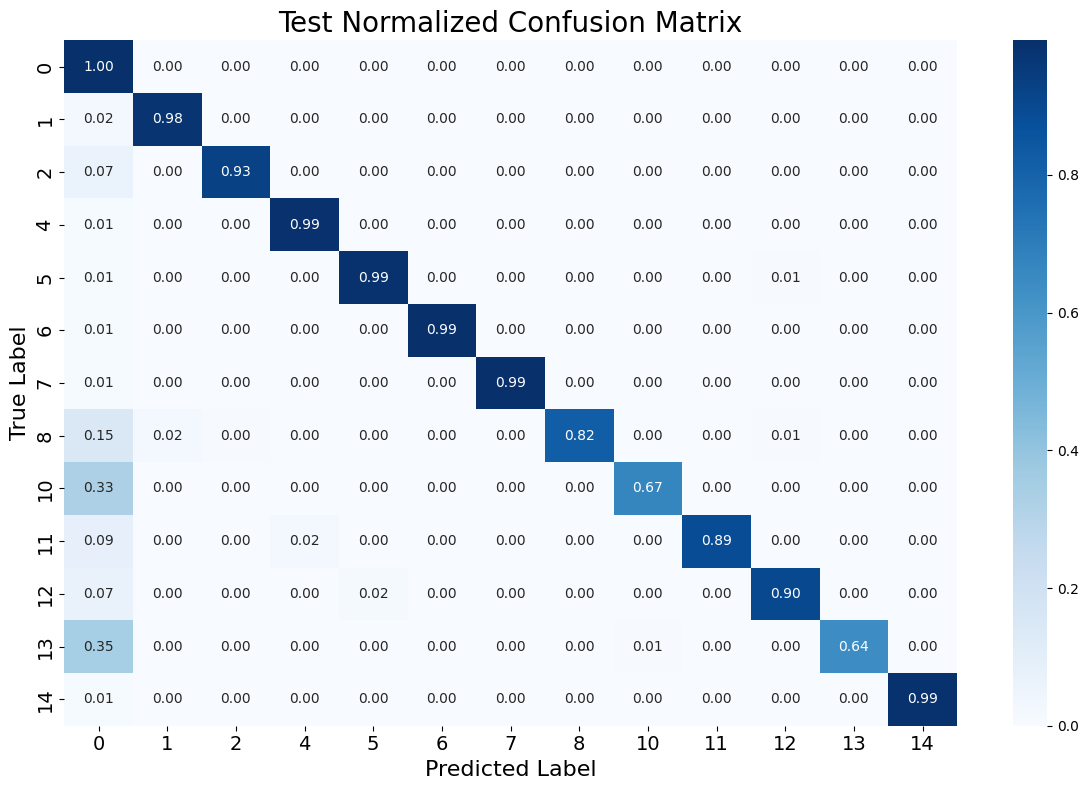

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Parameters
fault_intro_sample = 20
early_window_end = 140
lags = [1, 2]
ewma_span = 3
group_col = "simulationRun"
label_col = "faultNumber"

# Load Data
PROJECT_ROOT = Path.cwd().parent
ff_train_path = PROJECT_ROOT / "data" / "TEP_FaultFree_Training_fault_free_training.pkl"
f_train_path  = PROJECT_ROOT / "data" / "TEP_Faulty_Training_faulty_training.pkl"
ff_train = pd.read_pickle(ff_train_path)
f_train  = pd.read_pickle(f_train_path)

# Offset simulationRun to avoid collisions with fault-free run IDs
f_train[group_col] += 500

# Assign fault label to entire simulation
f_train["label"] = f_train["faultNumber"].astype(int)
ff_train["label"] = 0

# Meta + feature columns
meta_cols = ["sample", group_col, label_col, "label"]
feature_cols = [c for c in f_train.columns if c not in meta_cols]

# Feature engineering
def add_lags(df, features, lags, group_col):
    df = df.copy()
    for lag in lags:
        lagged = df.groupby(group_col)[features].shift(lag)
        lagged.columns = [f"{col}_lag{lag}" for col in features]
        df = pd.concat([df, lagged], axis=1)
    return df

def add_ewma(df, features, span, group_col):
    df = df.copy()
    for col in features:
        df[f"{col}_ewma"] = df.groupby(group_col)[col].transform(
            lambda x: x.ewm(span=span, adjust=False).mean()
        )
    return df

ff_train = add_lags(ff_train, feature_cols, lags, group_col)
f_train  = add_lags(f_train,  feature_cols, lags, group_col)

ff_train = add_ewma(ff_train, feature_cols, ewma_span, group_col)
f_train  = add_ewma(f_train,  feature_cols, ewma_span, group_col)

ff_train.dropna(inplace=True)
f_train.dropna(inplace=True)

# Filter faulty runs to early window + exclude certain faults
f_train_early = f_train[
    (f_train["sample"] >= fault_intro_sample) & (f_train["sample"] < early_window_end)
].copy()

exclude_faults = [3, 9] + list(range(15, 21))
f_train_early = f_train_early[~f_train_early["label"].isin(exclude_faults)]

# Assemble dataset
predictors = [
    c for c in f_train.columns
    if c.endswith("_lag1") or c.endswith("_lag2") or c.endswith("_ewma")
]

# Keep everything in one dataframe so we can split by run cleanly
ff_block = ff_train[[*predictors, "sample", group_col, "label"]].copy()
f_block  = f_train_early[[*predictors, "sample", group_col, "label"]].copy()

data_all = pd.concat([ff_block, f_block], ignore_index=True)

# Encode labels AFTER filtering/exclusion
label_encoder = LabelEncoder()
data_all["label_enc"] = label_encoder.fit_transform(data_all["label"])

# One row per run, with the run's label (label is constant per run in this dataset)
run_table = (
    data_all[[group_col, "label_enc"]]
    .drop_duplicates(subset=[group_col])
    .reset_index(drop=True)
)

run_ids = run_table[group_col].values
run_labels = run_table["label_enc"].values

# First split
try:
    train_runs, temp_runs = train_test_split(
        run_ids, test_size=0.4, random_state=42, stratify=run_labels
    )
except ValueError:
    # Fallback
    train_runs, temp_runs = train_test_split(
        run_ids, test_size=0.4, random_state=42
    )

# Second split
temp_labels = run_table.set_index(group_col).loc[temp_runs, "label_enc"].values
try:
    val_runs, test_runs = train_test_split(
        temp_runs, test_size=0.5, random_state=42, stratify=temp_labels
    )
except ValueError:
    val_runs, test_runs = train_test_split(
        temp_runs, test_size=0.5, random_state=42
    )

# Build splits by filtering rows belonging to those runs
train_df = data_all[data_all[group_col].isin(train_runs)].copy()
val_df   = data_all[data_all[group_col].isin(val_runs)].copy()
test_df  = data_all[data_all[group_col].isin(test_runs)].copy()

X_train = train_df[predictors]
y_train = train_df["label_enc"].values
meta_train = train_df[["sample", group_col, "label"]].copy()

X_val = val_df[predictors]
y_val = val_df["label_enc"].values
meta_val = val_df[["sample", group_col, "label"]].copy()

X_test = test_df[predictors]
y_test = test_df["label_enc"].values
meta_test = test_df[["sample", group_col, "label"]].copy()

print("Run counts:")
print(f"  Train runs: {len(train_runs)}")
print(f"  Val runs:   {len(val_runs)}")
print(f"  Test runs:  {len(test_runs)}")

# Train model
model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    subsample=0.6,
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    gamma=1,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)
# --- Use the exact feature set the model was trained on ---
trained_features = list(getattr(model, "feature_names_in_", predictors))
print("Model expects n_features =", len(trained_features))

# Evaluation
def evaluate_model(name, X_eval, y_eval, meta_eval, return_preds=False):
    y_pred_encoded = model.predict(X_eval)

    y_true = label_encoder.inverse_transform(y_eval)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    classes = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # normalize per true class
    cm_norm = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(f"{name} Normalized Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Label", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    if return_preds:
        out = meta_eval.copy()
        out["true_label"] = y_true
        out["pred_label"] = y_pred
        return out

# Evaluate
results_val = evaluate_model("Validation", X_val, y_val, meta_val, return_preds=True)
results_test = evaluate_model("Test", X_test, y_test, meta_test, return_preds=True)


Save Model

In [ ]:
import os
import joblib
from datetime import datetime

MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_artifact = {
    "model": model,
    "label_encoder": label_encoder,
    "predictors": predictors,
    "params": model.get_params(),
    "trained_at": datetime.utcnow().isoformat(),
    "fault_intro_sample": fault_intro_sample,
    "early_window_end": early_window_end,
    "lags": lags,
    "ewma_span": ewma_span
}

artifact_path = MODELS_DIR / "xgb_fault_detector.joblib"
joblib.dump(model_artifact, artifact_path)
print(f"Saved XGB model artifact to: {artifact_path}")


Saved XGB model artifact to: c:\Users\custu\My Drive\MSDS 498\early-fault-detection-and-RCA\models\xgb_fault_detector.joblib


C:\Users\custu\AppData\Local\Temp\ipykernel_6724\1232096601.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=detection_df, x="fault", y="detection_delay", palette="tab20")


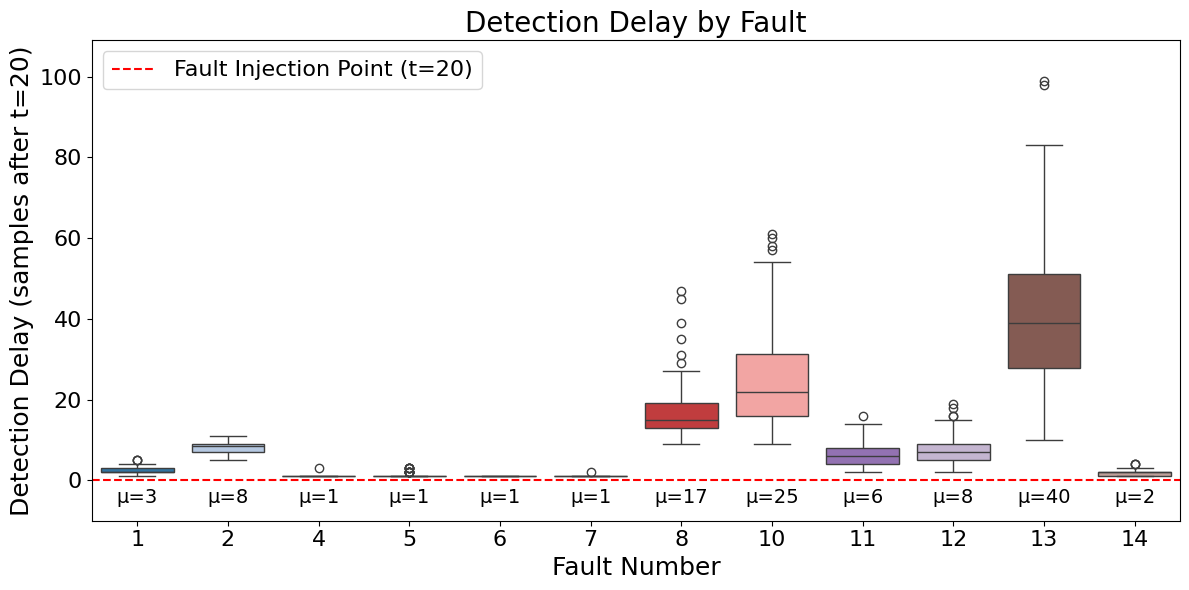

In [ ]:
meta_test = meta_test.copy()
meta_test["true_label"] = label_encoder.inverse_transform(y_test)
meta_test["pred_label"] = label_encoder.inverse_transform(model.predict(X_test))

# Only keep fault samples
fault_test = meta_test[meta_test["true_label"] > 0]

# Compute detection delay per simulation
records = []
for fault in sorted(fault_test["true_label"].unique()):
    fault_df = fault_test[fault_test["true_label"] == fault]
    for sim in fault_df["simulationRun"].unique():
        sim_df = fault_df[fault_df["simulationRun"] == sim]
        correct = sim_df[sim_df["pred_label"] == fault]
        if not correct.empty:
            first_detect = correct["sample"].min()
            delay = first_detect - fault_intro_sample
        else:
            first_detect = None
            delay = np.nan
        records.append({
            "fault": fault,
            "simulation": sim,
            "detection_sample": first_detect,
            "detection_delay": delay
        })

# Create and plot detection delay
detection_df = pd.DataFrame(records)
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=detection_df, x="fault", y="detection_delay", palette="tab20")
plt.axhline(0, color="red", linestyle="--", label="Fault Injection Point (t=20)")
means = detection_df.groupby("fault")["detection_delay"].mean()
for tick, fault in enumerate(sorted(detection_df["fault"].unique())):
    mean_val = means[fault]
    if not np.isnan(mean_val):
        ax.text(tick, -2, f"μ={round(mean_val)}", ha='center', va='top', fontsize=14, color="black")
plt.ylim(-10, detection_df["detection_delay"].max() + 10)
plt.ylabel("Detection Delay (samples after t=20)", fontsize=18)
plt.xlabel("Fault Number", fontsize=18)
plt.title("Detection Delay by Fault", fontsize=20)
plt.legend(fontsize=16, loc="upper left")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


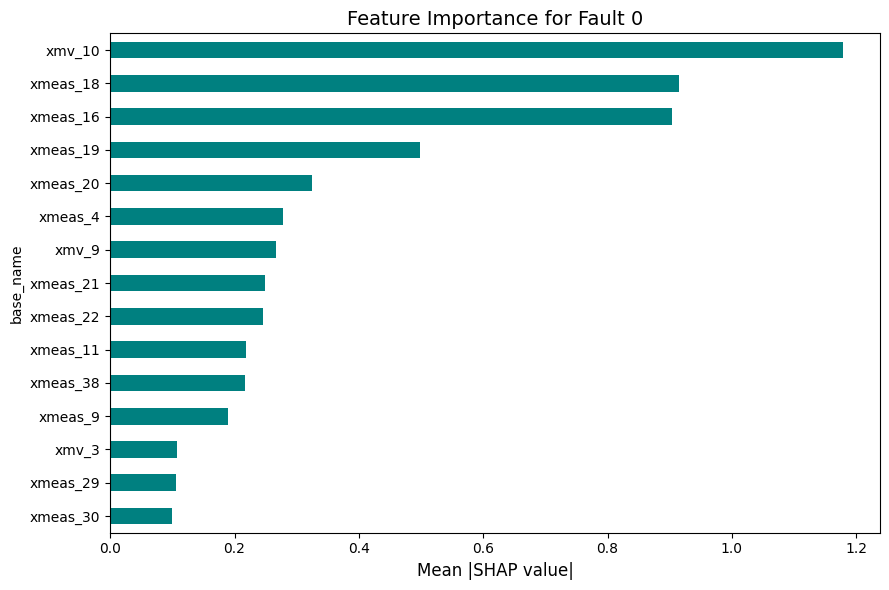

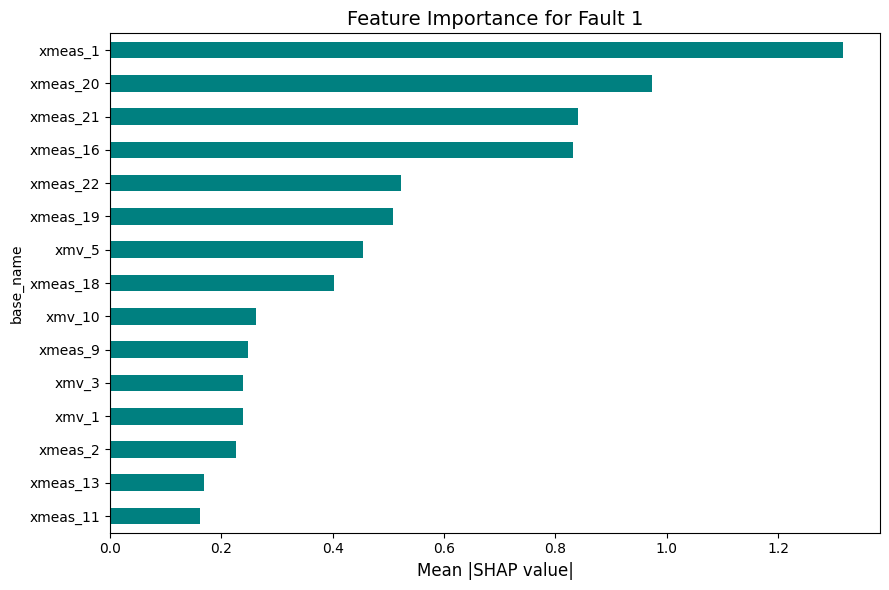

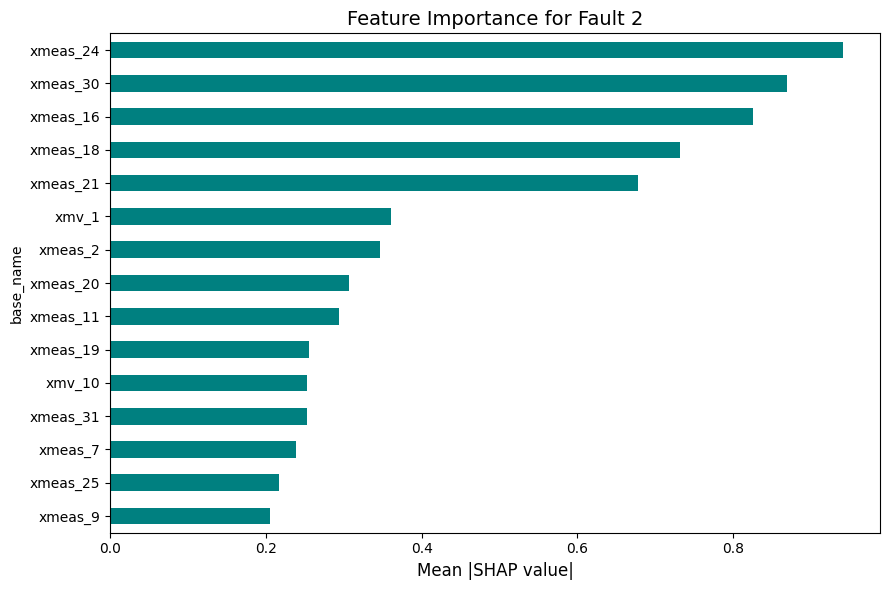

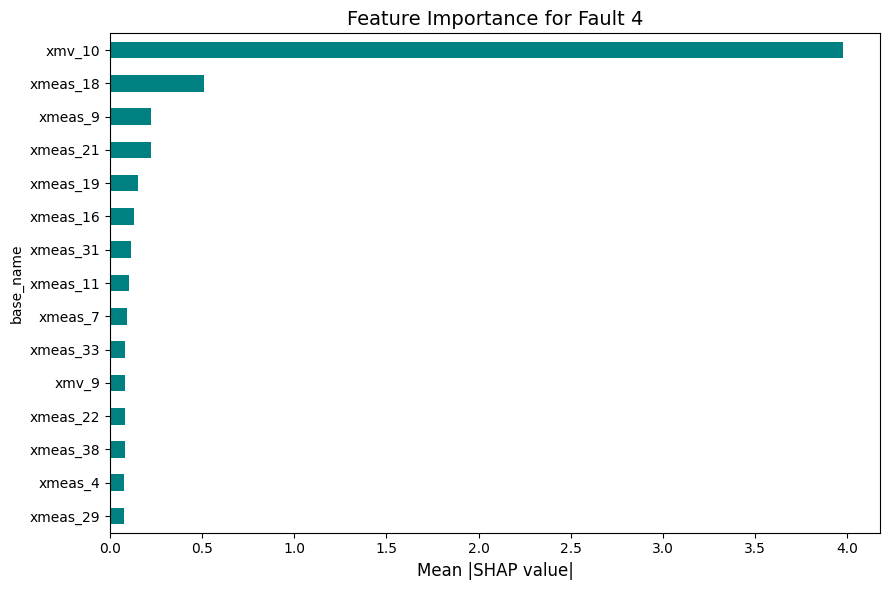

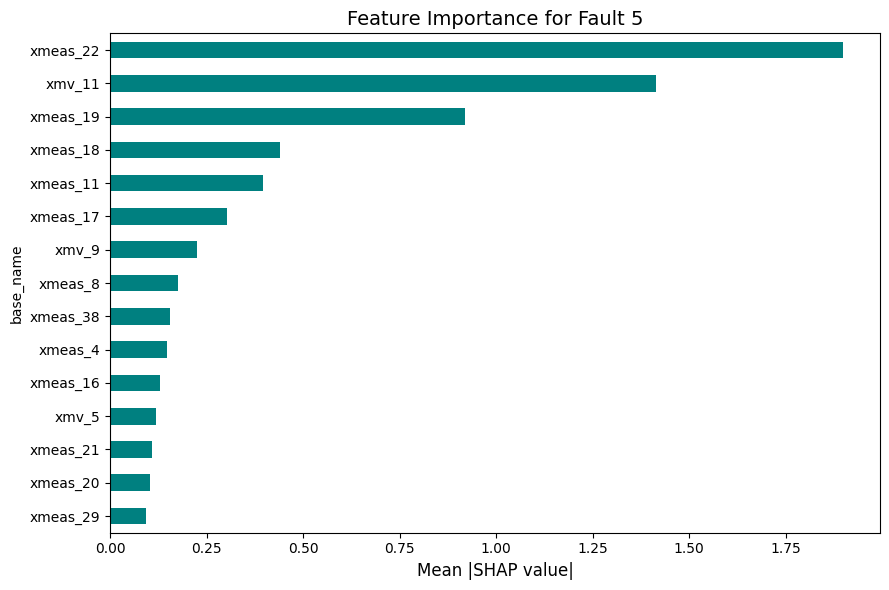

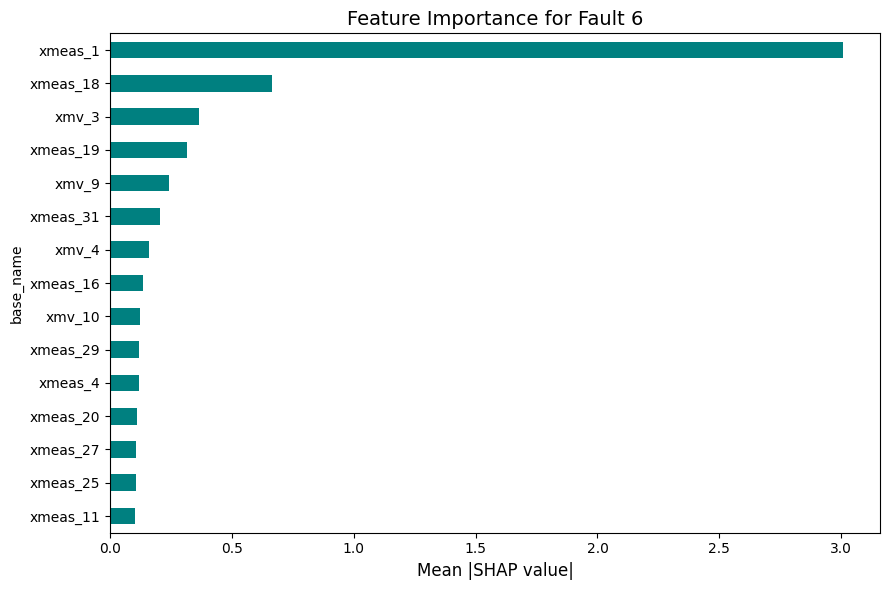

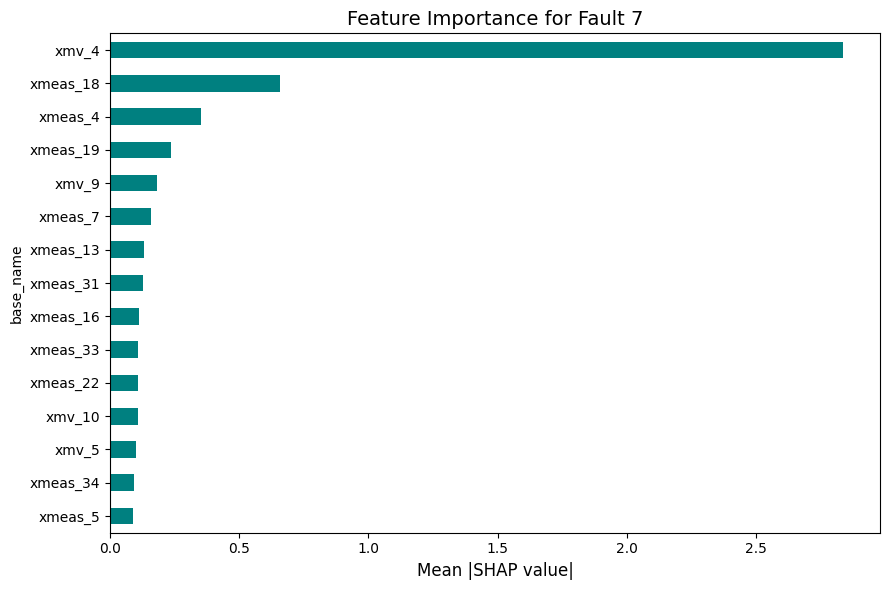

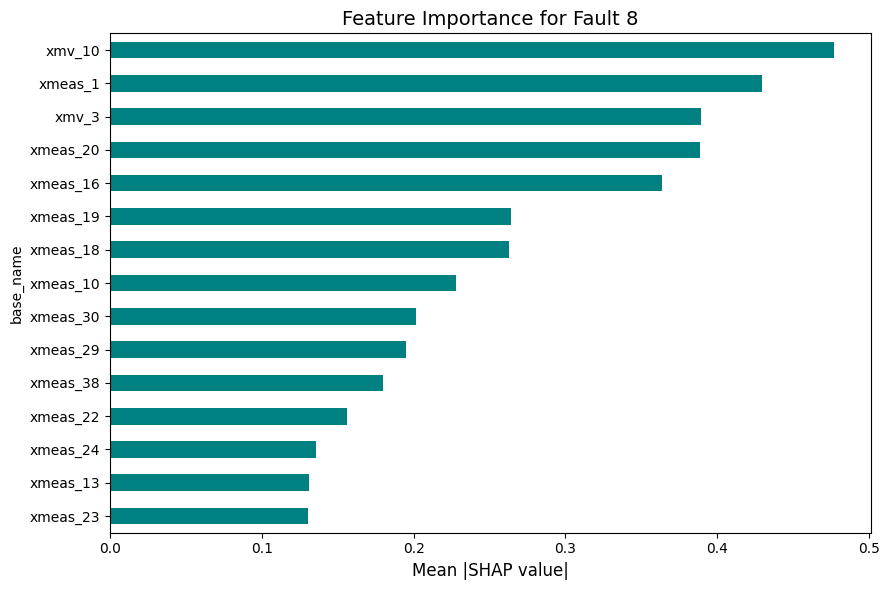

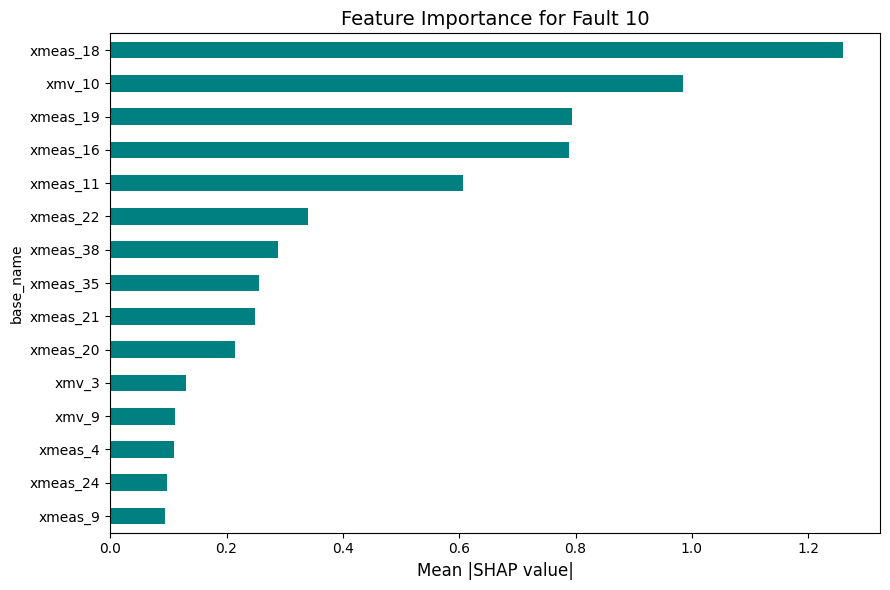

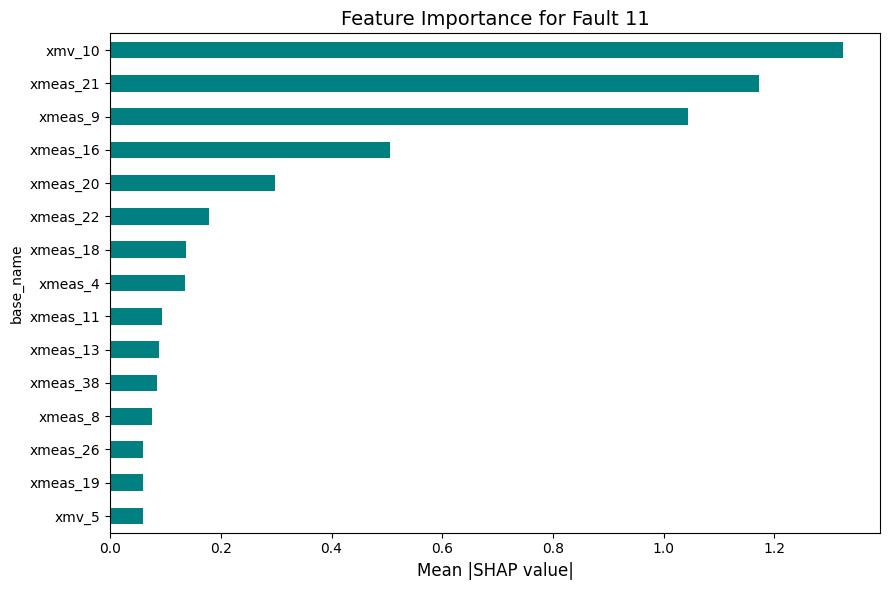

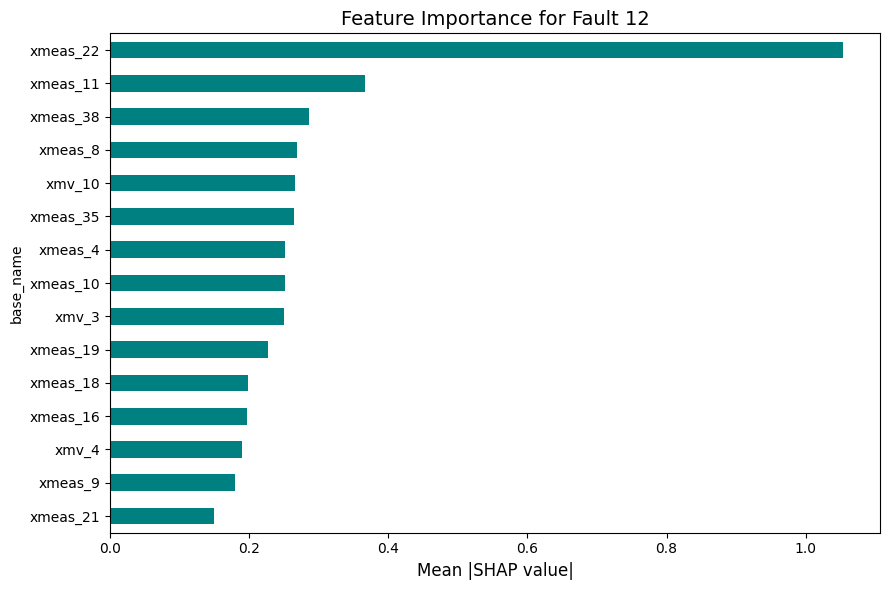

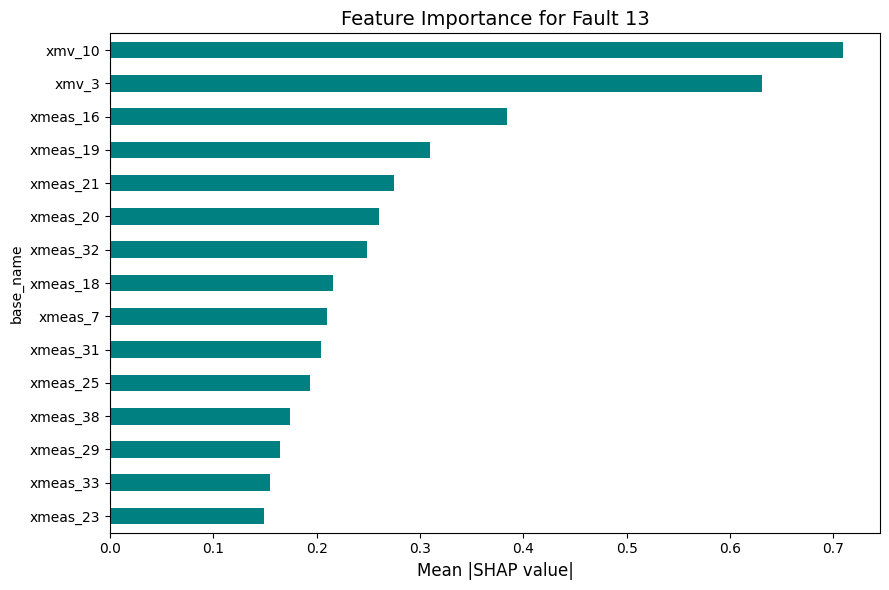

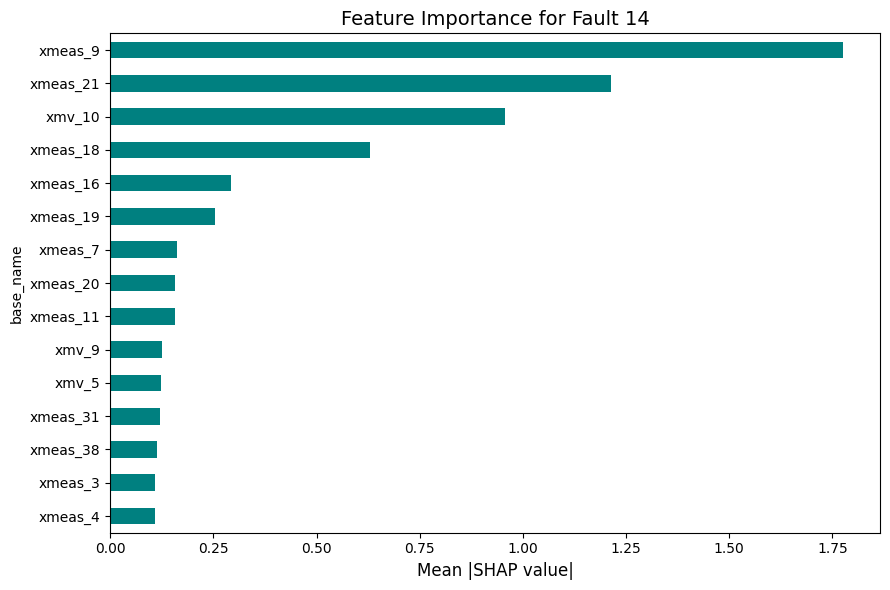

In [ ]:
import shap
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reuse previous sampling
y_val_decoded = label_encoder.inverse_transform(y_val)
val_df = X_val.copy()
val_df["faultNumber"] = y_val_decoded
sampled_df = val_df.groupby("faultNumber").sample(n=30, random_state=42)
X_sample = sampled_df.drop("faultNumber", axis=1)

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_sample)  # shape: (n_samples, n_features, n_classes)

# Base names
base_names = [re.sub(r"(_lag\d+|_ewma)$", "", feat) for feat in X_sample.columns]
base_name_map = dict(zip(X_sample.columns, base_names))

# Loop through classes
n_classes = shap_values.values.shape[2]
for class_idx in range(n_classes):
    # Get fault number label
    class_label = label_encoder.inverse_transform([class_idx])[0]

    # Mean absolute SHAP values for this class
    class_shap = np.abs(shap_values.values[:, :, class_idx]).mean(axis=0)
    shap_df = pd.DataFrame({
        "feature": X_sample.columns,
        "base_name": [base_name_map[feat] for feat in X_sample.columns],
        "mean_abs_shap": class_shap
    })

    # Group by base name
    shap_grouped = shap_df.groupby("base_name")["mean_abs_shap"].sum().sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(9, 6))
    shap_grouped.head(15).plot(kind="barh", color="teal")
    plt.xlabel("Mean |SHAP value|", fontsize=12)
    plt.title(f"Feature Importance for Fault {class_label}", fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


C:\Users\custu\AppData\Local\Temp\ipykernel_6724\1785298980.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.008229210041463375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[class_label, feat_name] += class_shap[i]
C:\Users\custu\AppData\Local\Temp\ipykernel_6724\1785298980.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009168625809252262' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[class_label, feat_name] += class_shap[i]
C:\Users\custu\AppData\Local\Temp\ipykernel_6724\1785298980.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.003656603628769517' has dtype incompatible with int64, please explicitly

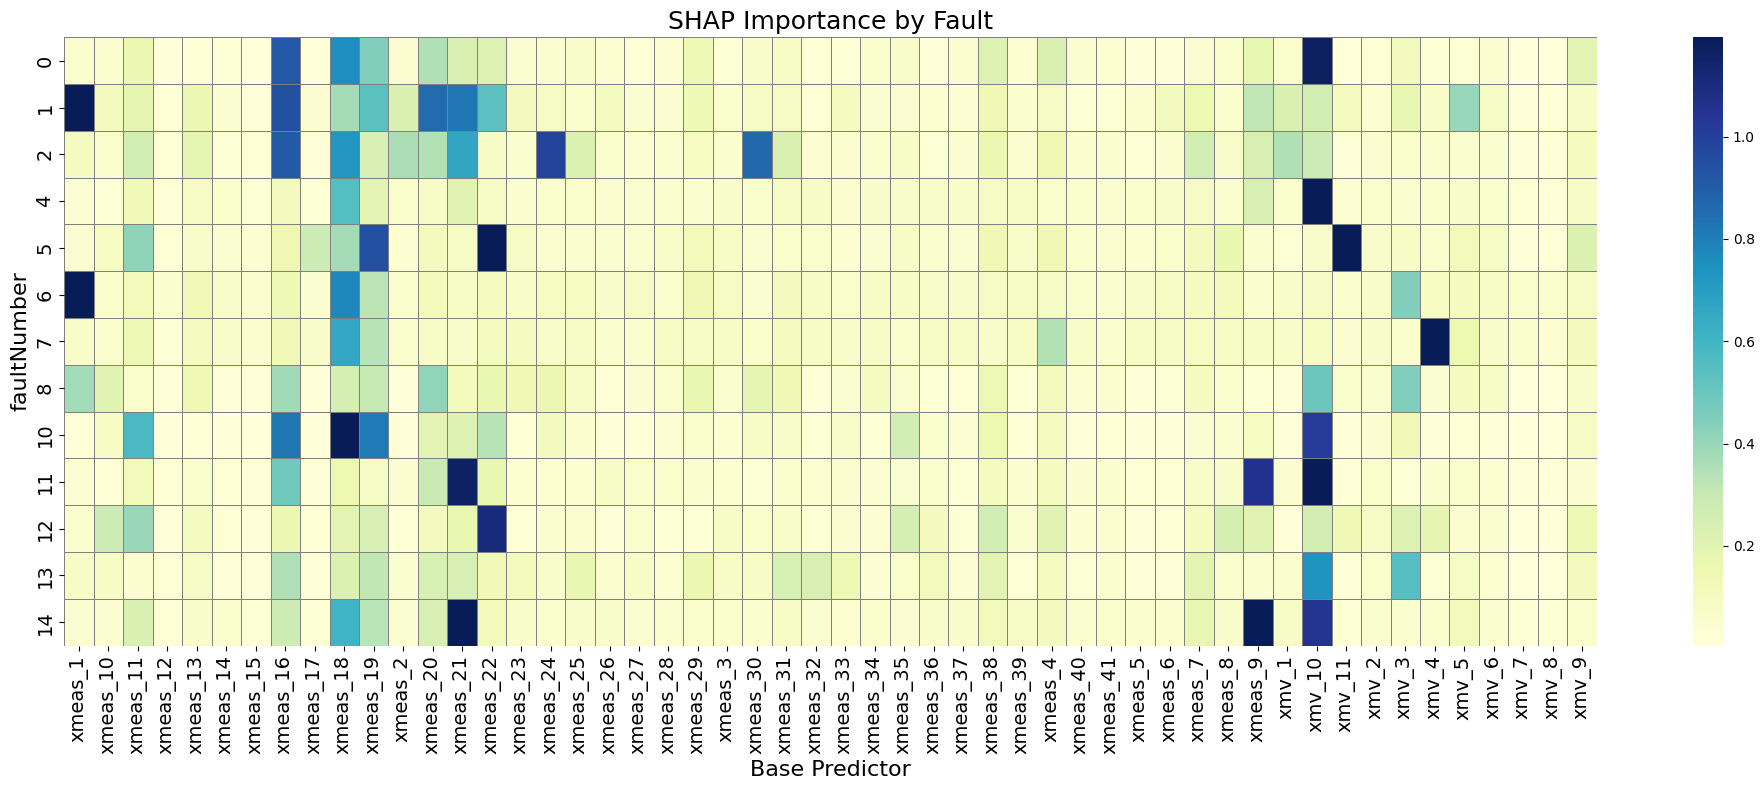

In [ ]:
import shap
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Resample 30 samples per fault type
y_val_decoded = label_encoder.inverse_transform(y_val)
val_df = X_val.copy()
val_df["faultNumber"] = y_val_decoded
sampled_df = val_df.groupby("faultNumber").sample(n=30, random_state=42)
X_sample = sampled_df.drop("faultNumber", axis=1)

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_sample)

# Prep base names
base_names = [re.sub(r"(_lag\d+|_ewma)$", "", feat) for feat in X_sample.columns]

# Aggregate SHAP values by feature + class
n_classes = shap_values.values.shape[2]
n_features = shap_values.values.shape[1]
heatmap_data = pd.DataFrame(0, index=sorted(np.unique(y_val_decoded)), columns=np.unique(base_names))

for class_idx in range(n_classes):
    class_label = label_encoder.inverse_transform([class_idx])[0]
    class_shap = np.abs(shap_values.values[:, :, class_idx]).mean(axis=0)

    for i, feat_name in enumerate(base_names):
        heatmap_data.loc[class_label, feat_name] += class_shap[i]

# heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

clipped_data = heatmap_data.clip(upper=heatmap_data.quantile(0.85).max())

plt.figure(figsize=(20, 8))
sns.heatmap(clipped_data, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title("SHAP Importance by Fault", fontsize=18)
plt.xlabel("Base Predictor", fontsize=16)
plt.ylabel("faultNumber", fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


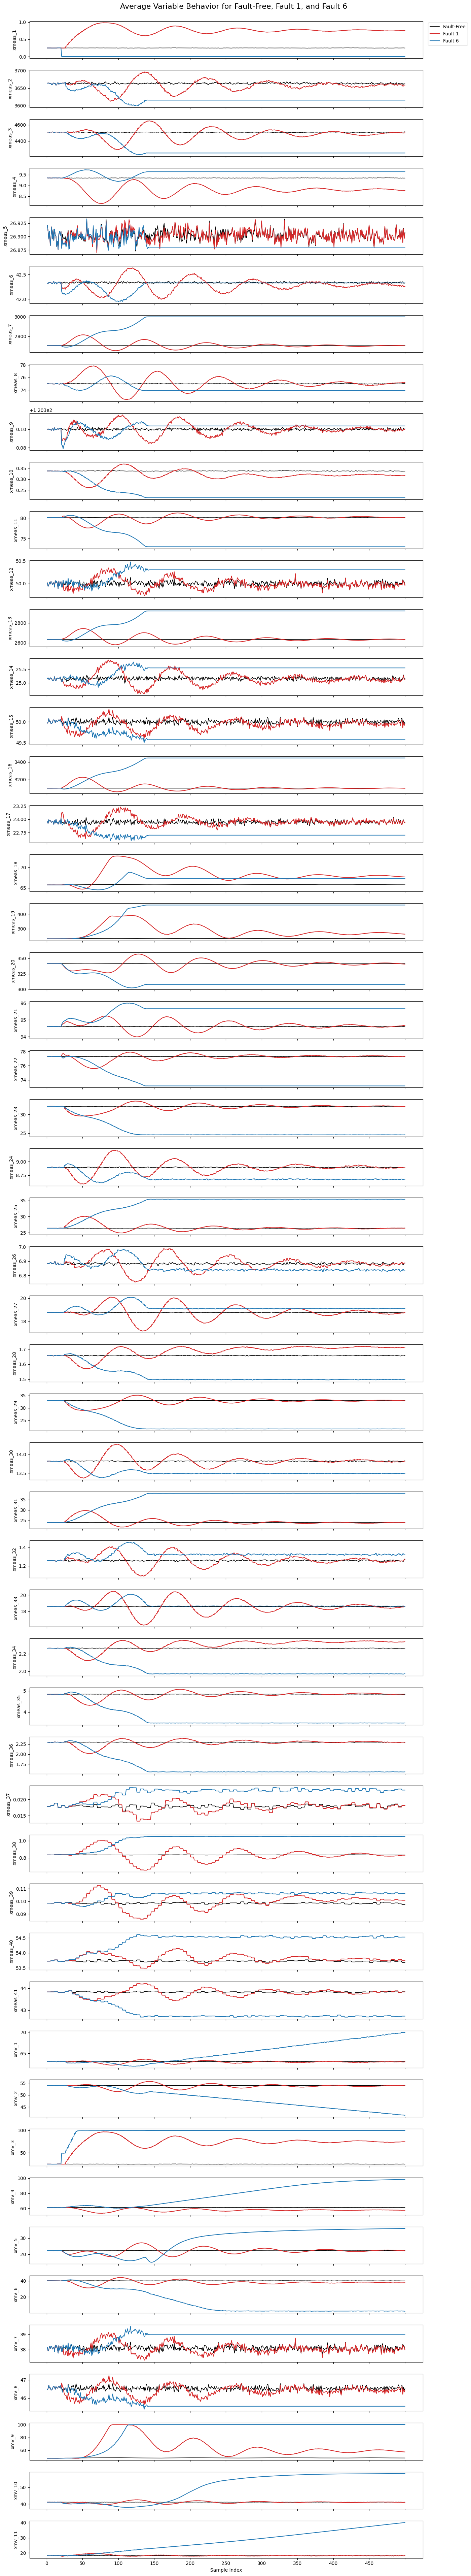

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load Data
ff_train = pd.read_pickle("TEP_FaultFree_Training_fault_free_training.pkl")
f_train = pd.read_pickle("TEP_Faulty_Training_faulty_training.pkl")

# Define Variables
feature_cols = [col for col in f_train.columns if col.lower().startswith("xmeas") or col.lower().startswith("xmv")]
samples_per_sim = 500

# Ensure 'simulationRun' exists
if "simulationRun" not in ff_train.columns:
    ff_train["simulationRun"] = ff_train.index // samples_per_sim
if "simulationRun" not in f_train.columns:
    f_train["simulationRun"] = f_train.index // samples_per_sim

# Compute mean for fault free
ff_mean = ff_train.groupby("sample")[feature_cols].mean()

# Compute mean for selected faults
selected_faults = [1, 6]
fault_means = {}
colors = {1: "tab:red", 6: "tab:blue"}

for fault_num in selected_faults:
    fault_df = f_train[f_train["faultNumber"] == fault_num]
    fault_means[fault_num] = fault_df.groupby("sample")[feature_cols].mean()

# Plot
num_vars = len(feature_cols)
fig, axes = plt.subplots(num_vars, 1, figsize=(14, num_vars * 1.5), sharex=True)
x_ticks = list(range(0, 500, 50))

for i, var in enumerate(feature_cols):
    ax = axes[i]
    ff_mean[var].plot(ax=ax, label="Fault-Free", color='black', linewidth=1.2)
    for fault_num, df in fault_means.items():
        df[var].plot(ax=ax, label=f"Fault {fault_num}", color=colors[fault_num])
    ax.set_ylabel(var)
    ax.set_xticks(x_ticks)
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.12, 1.02), ncol=1)

plt.xlabel("Sample Index")
plt.suptitle("Average Variable Behavior for Fault-Free, Fault 1, and Fault 6", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
